In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Code adapted from QizGloria team, Qiskit Camp Europe 2019, updated by 
# Team Ube Pancake, Qiskit Summer Jam 2020

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim

In [3]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
np.random.seed = 42

NUM_QUBITS = 1

NUM_SHOTS = 10000

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:5")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the GPU


Define function to translate Q-Circuit parameters from pytorch back to QISKIT

In [8]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

## QiskitCircuit()

Parameters have to be defined according to the circuit. In this case we have a unitary U3 with 3 parameters, which we call Theta, Phi and Lambda.
The paramter `shots` always has to be defined. It gives the number of measurements done on the simulator or on the hardware to do the averages for the expectation values.

### create_circuit()
Define a quantum cirquit in QISKIT language

### N_qubit_expectation_Z()
This is a function that allows to take the measurements and translate them to Z-expectation values for every single qubit.

### bind( parameters )
Takes the Neural Network parameters and puts them into a format that can be fed into the QIKSIT unitaries.

To generalze this code we would have to write a function that replaces the line `self.circuit.data[2][0]._params`.
Because the `self.circuit.data` is a list of all the gates  of the circuit. And the indices direct to the correct gate, where the parameters have to go.

At some point we would need a better scheme here.

### run( parameters )
This function puts the circuit with the given parameters on a quantum simulater or hardware and returns the measurements of every qubit in Z-basis

In [9]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        
        self.theta = Parameter('Theta')
        self.phi = Parameter('Phi')
        self.lam = Parameter('Lambda')
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        self.circuit.u3(self.theta, self.phi, self.lam, all_qubits)
        self.circuit.barrier()
        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects
    
    def run(self, i):
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,
                          self.backend,
                          shots=self.shots,
                          parameter_binds=[{self.theta : i[0].item(),
                                            self.phi : i[1].item(),
                                            self.lam : i[2].item()}])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

Expected value for rotation [pi/4, pi/4, pi/4]: 0.5096


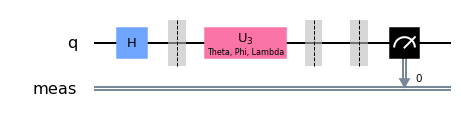

In [11]:
circuit = QiskitCircuit(1, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4, pi/4, pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4, np.pi/4, np.pi/4]))[0]))
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]))[0]))
circuit.circuit.draw(output='mpl', filename='Figures/{}-qubit u3-circuit.jpg'.format(NUM_QUBITS))

### TorchCircuit()

A pytorch layer always has two functions. One for the forward pass and one for the backward pass. The forward pass simply takes the Quantum Circuits variational parameters from the previous pytorch layer and runs the circuit on the defined hardware (defined in `QiskitCircuit.run()`) and returns the measurements from the quantum hardware.
These measurements will be the inputs of the next pytorch layer.

The backward pass returns the gradients of the quantum circuit. In this case here it is finite difference.

the `forward_tensor` is saved from the forward pass. So we just have to do one evaluation of the Q-Circuit in the backpass for the finite difference.

The `gradient` variable here is as well hard coded to 3 parameters. This should be updated in the future and made more general.

The loop `for k in range(len(input_numbers)):` goes through all the parameters (in this case 3), and shifts them by a small $\epsilon$. Then it runs the circuit and takes the diefferences of the ouput for the parameters $\Theta$ and $\Theta + \epsilon$. This is the finite difference. 

In [12]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(1, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors
#         print(i)
        input_numbers = to_numbers(i[0])
#         print(input_numbers)
        gradient = [0,0,0]
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps
            exp_value = ctx.QiskitCirc.run(torch.tensor(input_eps))[0]
            gradient_result = (exp_value - forward_tensor[0][0].item())#/eps
            gradient[k] = gradient_result
            
#         print(gradient)
        result = torch.tensor([gradient])
#         print(result)

        return result.float() * grad_output.float()

In [14]:
x = torch.tensor([[np.pi/4, np.pi/4, np.pi/4]], requires_grad=True)
#x = torch.tensor([[np.pi/4]], requires_grad=True)
# x = torch.tensor([[0.0, 0.0, 0.0]], requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
y1.backward()
print(x.grad)

tensor([[0.0056, 0.0280, 0.0244]])


### Test the Quantum Circuit separately

This example is simply to test the QC with a pytorch optimizer

We define a cost function and a target expectation value (here -1). The cost is the square distance from the target value.

`x` is the initialization of the parameters. Here again, this was hard coded such that every angle starts at $\pi / 4$.

The rest is standard pytorch optimization

100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


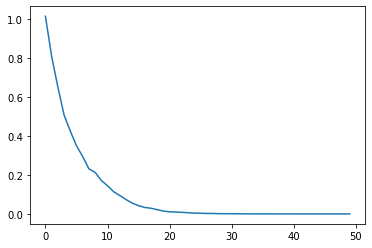

In [16]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)
    return torch.abs(qc(x) - target) ** 2, expval

x = torch.tensor([[-np.pi/2, -np.pi/2, -np.pi/2]], requires_grad=True)
#x = torch.tensor([[-np.pi/2]], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 50

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))

### MNIST in pytorch

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Load MNIST

In this code we can not handle batches yet.
This should be implemented as well

In [20]:
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, transforms
from torch import Tensor, save
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
#from torch.nn import Linear
#from torch.nn import ReLU
#from torch.nn import Softmax
#from torch.nn import Module
#from torch.optim import SGD
#from torch.nn import CrossEntropyLoss

img_dimensions = 300
batch_size = 1
learning_rate = 0.01
momentum = 0.5
n_datapoints = 100


torch.backends.cudnn.enabled = False

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets #get labels
labels = labels.numpy()
idx1 = np.where(labels == 0) #search all zeros
idx2 = np.where(labels == 1) # search all ones
idx = np.concatenate((idx1[0][0:n_datapoints//2],idx2[0][0:n_datapoints//2])) # concatenate their indices
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

print(mnist_trainset)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

'''
img_transforms = transforms.Compose([
    transforms.Resize((img_dimensions, img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

img_test_transforms = transforms.Compose([
    transforms.Resize((img_dimensions,img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

train_data_path = "/home/wtf/dogs-vs-cats/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)

validation_data_path = "/home/wtf/dogs-vs-cats/validation/"
validation_data = torchvision.datasets.ImageFolder(root=validation_data_path,transform=img_test_transforms, is_valid_file=check_image)

test_data_path = "/home/wtf/dogs-vs-cats/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_test_transforms, is_valid_file=check_image)

num_workers = 6
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)


if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
'''

Dataset MNIST
    Number of datapoints: 100
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


'\nimg_transforms = transforms.Compose([\n    transforms.Resize((img_dimensions, img_dimensions)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )\n    ])\n\nimg_test_transforms = transforms.Compose([\n    transforms.Resize((img_dimensions,img_dimensions)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )\n    ])\n\ndef check_image(path):\n    try:\n        im = Image.open(path)\n        return True\n    except:\n        return False\n\ntrain_data_path = "/home/wtf/dogs-vs-cats/train/"\ntrain_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)\n\nvalidation_data_path = "/home/wtf/dogs-vs-cats/validation/"\nvalidation_data = torchvision.datasets.ImageFolder(root=validation_data_path,transform=img_test_transforms, is_valid_file=check_image)\n\ntest_data_path = "/home/wtf/dogs-vs-cats/test/"\ntest_data = torc

### Define Neural Network with Q-node

This NN is  2 layers of ConvNN and a fully connected layer, with a Q-Node as a classifier.

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        x = qc(x) # This is the q node
        x = (x+1)/2 # Translate expectation values [-1,1] to labels [0,1]
        x = torch.cat((x, 1-x), -1)
        return x

In [26]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

### Training loop

standard pytorch training loop.
- Load data from train_loader. Which is this case a single example each step.
- Forward pass through NN
- Caluculate loss
- Backprop and optimize

In [28]:
epochs = 20
loss_list = []

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        #print(data.shape)
        output = network(data)
        # Calculating loss
        loss = F.nll_loss(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.5215
Training [10%]	Loss: -0.5354
Training [15%]	Loss: -0.5330
Training [20%]	Loss: -0.5457
Training [25%]	Loss: -0.5666
Training [30%]	Loss: -0.5468
Training [35%]	Loss: -0.5629
Training [40%]	Loss: -0.5685
Training [45%]	Loss: -0.5955
Training [50%]	Loss: -0.6135
Training [55%]	Loss: -0.5951
Training [60%]	Loss: -0.6327
Training [85%]	Loss: -0.7119
Training [90%]	Loss: -0.7169
Training [95%]	Loss: -0.7505
Training [100%]	Loss: -0.7411


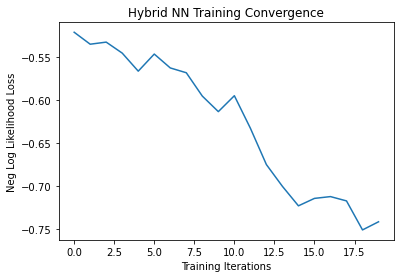

In [29]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')
plt.savefig('Figures/{}-qubit Loss Curve u3.jpg'.format(NUM_QUBITS))

### Test accuracy of NN

The outcome is not always the same because the prediction is probabilistic.

In [30]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(train_loader):
    number +=1
    output = network(data)
    output = (output>0.5).float()
    accuracy += (output[0][1].item() == target[0].item())*1
    
print("Performance on test data is is: {}".format(accuracy/number))    

Performance on test data is is: 0.87


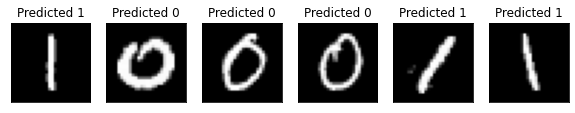

In [31]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        if count == n_samples_show:
            break
        output = network(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1